In [2]:
import sys, os
import numpy as np
import h5py
import random
import neptune
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from tqdm import tqdm
from tensorflow import keras
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, MaxPooling2D, Conv2D, Conv2DTranspose, Flatten, Dropout, Dense, BatchNormalization, Activation, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow_probability.python.distributions import kl_divergence
from neptune.integrations.tensorflow_keras import NeptuneCallback
from DataMaker import *

2023-08-06 09:04:34.787562: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-06 09:04:35.452773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
LATENT_DIM = 128
BASE_DEPTH = 8
IMAGE_SHAPE = (5, 64, 64)
BATCH_SIZE = 512
EPOCHS = 250
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-3

In [5]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-08-06 09:04:37.611096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-06 09:04:37.658535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-06 09:04:37.658740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
args_gen = {'X_key' : 'image',
    'y_key' : 'specz_redshift',
    'scaler' : False,
    'labels_encoding' : False,
    'batch_size': BATCH_SIZE,
    'mode' : 'train',
    'shuffle' : False}

train_gen = HDF5ImageGenerator(src = '/data/tuando/data/HSC/HSC_v6/step3A/64x64/5x64x64_training_z_less_than_2.hdf5', **args_gen)
test_gen = HDF5ImageGenerator(src = '/data/tuando/data/HSC/HSC_v6/step3A/64x64/5x64x64_testing_z_less_than_2.hdf5', **args_gen)
val_gen = HDF5ImageGenerator(src = '/data/tuando/data/HSC/HSC_v6/step3A/64x64/5x64x64_validation_z_less_than_2.hdf5', **args_gen)

In [9]:
prior = tfd.Independent(tfd.Normal(loc = tf.zeros(LATENT_DIM), scale = 1.0), reinterpreted_batch_ndims = 1)

# Encoder
images = Input(shape = IMAGE_SHAPE)
redshifts = Input(shape = (1, ))
conv1 = Conv2D(32, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(images)
conv2 = Conv2D(64, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(conv1)
conv3 = Conv2D(128, 2, strides = 1, activation = "relu", padding = 'same', data_format = 'channels_first')(conv2)
conv4 = Conv2D(256, 2, strides = 1, activation = "relu", padding = 'same', data_format = 'channels_first')(conv3)
flatten = Flatten()(conv4)
concat = tf.keras.layers.Concatenate()([flatten, redshifts])
dense1 = Dense(1024, activation = "relu")(concat)
dense2 = Dense(1024, activation = "relu")(dense1)
dense3 = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(dense2)
z = tfpl.MultivariateNormalTriL(LATENT_DIM, activity_regularizer = tfpl.KLDivergenceRegularizer(prior, weight = KL_WEIGHT))(dense3)
encoder = Model([images, redshifts], z)

In [10]:
zc = Input(shape = (LATENT_DIM + 1, ))
dense4 = Dense(1024, activation = "relu")(zc)
dense5 = Dense(1024, activation = "relu")(dense4) # Size of the dense layer changed
dense6 = Dense(256 * 16 * 16, activation = "relu")(dense5) # Size of the dense layer changed
reshape = Reshape((256, 16, 16))(dense6) # Reshape size changed
conv5 = Conv2DTranspose(128, 2, strides = 1, activation = "relu", padding = 'same', data_format = 'channels_first')(reshape)
conv6 = Conv2DTranspose(64, 2, strides = 1, activation = "relu", padding = 'same', data_format = 'channels_first')(conv5)
conv7 = Conv2DTranspose(32, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(conv6)
conv8 = Conv2DTranspose(5, 3, strides = 2, activation = "sigmoid", padding = 'same', data_format = 'channels_first')(conv7)
outputs = Reshape(IMAGE_SHAPE)(conv8)
decoder = Model(zc, outputs)

In [11]:
z = encoder([images, redshifts])
zc = tf.keras.layers.Concatenate()([z, redshifts])  # Assuming you want to concat the output of encoder and redshifts
decoder_output = decoder(zc)

model = Model(inputs=[images, redshifts], outputs = decoder_output)

In [12]:
encoder.summary()
decoder.summary()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 64, 64)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   1472        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 16, 16)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 128, 16, 16)  32896       ['conv2d_1[0][0]']               
                                                                                              

In [13]:
optimizer = Adam(learning_rate = 0.0001)
model.compile(optimizer = optimizer, loss = 'mse')

In [14]:
run = neptune.init_run(
    name = MODEL_SUBVERSION,
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

model_name = 'cvae_rockfish'

weights_path = os.path.join('/data/tuando/models/', model_name) + '/weights'

neptune_callback = NeptuneCallback(run = run)

LR_CALLBACK = ReduceLROnPlateau()

/tmp/ipykernel_3860883/1874926983.py:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/astro-data-lab/VAE/e/VAE-183


In [15]:
history = model.fit(train_gen, epochs = 100, callbacks = [neptune_callback, LR_callback], validation_data = val_gen, verbose = 1)

Epoch 1/100


2023-08-06 09:04:42.857946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-08-06 09:04:45.871922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-06 09:04:46.601926: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-06 09:04:46.713352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-06 09:04:47.279861: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f91f9cdfc00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-06 09:04:47.279881: I tensorflo

350/350 [==============================] - ETA: 0s - loss: 9.7795

2023-08-06 09:07:22.165563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


350/350 [==============================] - 191s 527ms/step - loss: 9.7795 - val_loss: 9.7518 - lr: 1.0000e-04
Epoch 2/100
350/350 [==============================] - 144s 412ms/step - loss: 9.5960 - val_loss: 9.7434 - lr: 1.0000e-04
Epoch 3/100
350/350 [==============================] - 200s 573ms/step - loss: 9.5921 - val_loss: 9.7415 - lr: 1.0000e-04
Epoch 4/100
350/350 [==============================] - 87s 249ms/step - loss: 9.5907 - val_loss: 9.7407 - lr: 1.0000e-04
Epoch 5/100
350/350 [==============================] - 40s 114ms/step - loss: 9.5897 - val_loss: 9.7399 - lr: 1.0000e-04
Epoch 6/100
350/350 [==============================] - 38s 108ms/step - loss: 9.5897 - val_loss: 9.7423 - lr: 1.0000e-04
Epoch 7/100
350/350 [==============================] - 33s 95ms/step - loss: 9.5891 - val_loss: 9.7393 - lr: 1.0000e-04
Epoch 8/100
350/350 [==============================] - 34s 97ms/step - loss: 9.5886 - val_loss: 9.7387 - lr: 1.0000e-04
Epoch 9/100
350/350 [======================

In [16]:
model.save_weights(weights_path)

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = '/data3/Billy/models/HSC_v6_CVAE_v1.0/v1.0.20230806_09_04_38/model/data3/Billy/CVAE/weights.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [ ]:
model.load_weights(weights_path)

z = 0.835348487


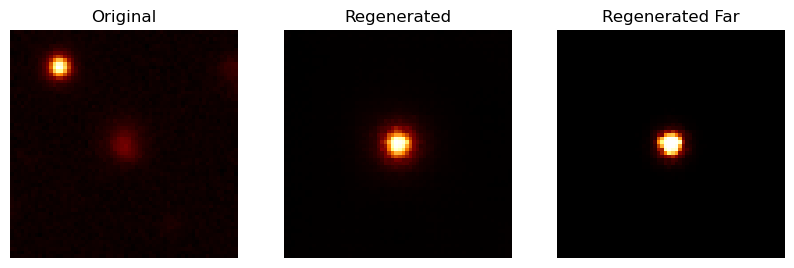

In [17]:
lib = 3
index = 466
z = test_gen[lib][0][1][index]
z_shifted = 2
band = 0
print(f'z = {z}')
str = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str = np.concatenate((str, np.array([z])))
str = str.reshape(1, LATENT_DIM + 1)
str_shifted = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str_shifted = np.concatenate((str_shifted, np.array([z_shifted])))
str_shifted = str_shifted.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
axes[0].imshow(test_gen[lib][0][0][index][band], cmap = 'afmhot')
axes[1].imshow(decoder([str])[0][band], cmap = 'afmhot')
axes[2].imshow(decoder([str_shifted])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title("Original")
axes[1].set_title("Regenerated")
axes[2].set_title("Regenerated Far")
plt.show()

z = 0.587000012


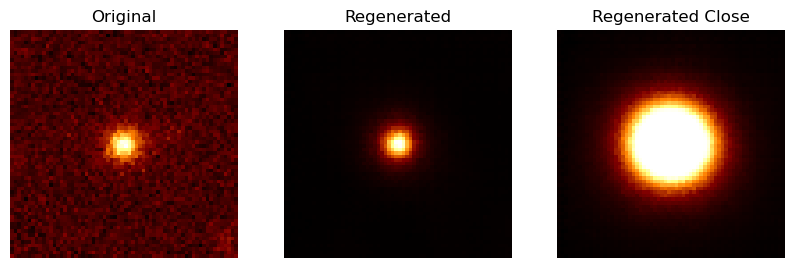

In [18]:
lib = 5
index = 273
z = test_gen[lib][0][1][index]
z_shifted = 0.1
band = 0
print(f'z = {z}')
str = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str = np.concatenate((str, np.array([z])))
str = str.reshape(1, LATENT_DIM + 1)
str_shifted = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str_shifted = np.concatenate((str_shifted, np.array([z_shifted])))
str_shifted = str_shifted.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
axes[0].imshow(test_gen[lib][0][0][index][band], cmap = 'afmhot')
axes[1].imshow(decoder([str])[0][band], cmap = 'afmhot')
axes[2].imshow(decoder([str_shifted])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title("Original")
axes[1].set_title("Regenerated")
axes[2].set_title("Regenerated Close")
plt.show()

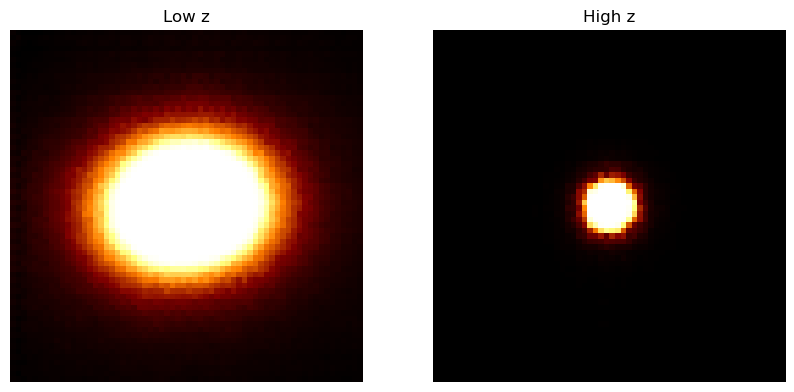

In [20]:
band = 0
str = prior.sample(1)[0]
strlo = np.concatenate((str, np.array([0.1])))
strlo = strlo.reshape(1, LATENT_DIM + 1)
strhi = np.concatenate((str, np.array([2])))
strhi = strhi.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].imshow(decoder([strlo])[0][band], cmap = 'afmhot')
axes[1].imshow(decoder([strhi])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title("Low z")
axes[1].set_title("High z")
plt.show()

In [ ]:
def scatter_bands_max_near_center(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.amax(np.array([test_gen[0][0][0][i][j]])))
            pred_array = np.append(pred_array, np.amax(np.transpose(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j][60:67]))[60:67].flatten()))
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel("Bands")
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel(f"Maximum normalized pixel value z = {np.array([test_gen[0][0][1][i]])[0]}")
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()

def scatter_bands_max(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.amax(np.array([test_gen[0][0][0][i][j]])))
            pred_array = np.append(pred_array, np.amax(np.array([model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]])))
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel("Bands")
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel("Maximum normalized pixel value")
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()
        
def scatter_bands_center(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.array([test_gen[0][0][0][i][j]])[0][63][63])
            pred_array = np.append(pred_array, model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j][63][63])
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel("Bands")
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel(f"Central pixel value z = {np.array([test_gen[0][0][1][i]])}")
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()
        
def scatter_bands_center_shift(lib = 3, i = 37, z = 1):
    print(z)
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
    x_array = np.arange(5)
    true_array = np.array([])
    pred_array = np.array([])
    for j in range(0, 5):
        true_array = np.append(true_array, np.array([test_gen[lib][0][0][i][j]])[0][63][63])
        pred_array = np.append(pred_array, model([np.array([test_gen[lib][0][0][i]]), np.array([z])])[0][j][63][63])
    axes.scatter(x_array, true_array, c = 'blue', label = 'True')
    axes.scatter(x_array, pred_array, c = 'red', label = 'Predicted')
    axes.set_xlabel("Bands")
    axes.set_ylabel("Central pixel value")
    axes.legend()
    
def scatter_bands_max_shift(lib = 3, i = 37, z = 1):
    print(z)
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
    x_array = np.arange(5)
    true_array = np.array([])
    pred_array = np.array([])
    for j in range(0, 5):
        true_array = np.append(true_array, np.amax(np.array([test_gen[lib][0][0][i][j]])))
        pred_array = np.append(pred_array, np.amax(np.array([model([np.array([test_gen[lib][0][0][i]]), np.array([z])])[0][j]])))
    axes.scatter(x_array, true_array, c = 'blue', label = 'True')
    axes.scatter(x_array, pred_array, c = 'red', label = 'Predicted')
    axes.set_xlabel("Bands")
    axes.set_ylabel("Central pixel value")
    axes.legend()

def scatter_bands_percentile(percentile = 90, num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show /  5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_90 = np.percentile(np.array([test_gen[0][0][0][i][j]]).flatten(), percentile)
            pred_90 = np.percentile(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]).flatten(), percentile)
            true_array = np.append(true_array, true_90)
            pred_array = np.append(pred_array, pred_90)
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel('Bands')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel(f'{percentile}th percentile normalized pixel value')
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()

def scatter_bands_mean(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_mean = np.mean(np.array([test_gen[0][0][0][i][j]]).flatten())
            pred_mean = np.mean(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]).flatten())
            true_array = np.append(true_array, true_mean)
            pred_array = np.append(pred_array, pred_mean)
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel('Bands')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel('Mean normalized pixel value')
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()

def display_histograms(num_to_show = 2, index = 0):
    fig, axes = plt.subplots(nrows = num_to_show, ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        for j in range(0, 5):
            true_arr = sorted(np.array([test_gen[0][0][0][i][j]]).flatten())
            pred_arr = sorted(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]).flatten())
            true_arr = true_arr[0 : int(len(true_arr) * .99)]
            pred_arr = pred_arr[0 : int(len(pred_arr) * .99)]
            axes[i][j].hist(true_arr, 100, color = 'blue', label = 'True', alpha = 0.5)
            axes[i][j].hist(pred_arr, 100, color = 'red', label = 'Predicted', alpha = 0.5)
            axes[i][j].set_xlabel("Pixel Values")
            axes[i][j].set_ylabel("Count")
            axes[i][j].legend()
    fig.suptitle('Histograms of Predicted vs. True Image, Horizontal are Bands')
    
def display_5_bands(index):
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 10))
    loss = round(model.evaluate([np.array([test_gen[0][0][0][index]]), np.array([test_gen[0][0][1][index]])], np.array([test_gen[0][0][0][index]]), verbose = 0), 2)
    for i in range(0, 5):
        axes[0][i].imshow(np.array([test_gen[0][0][0][index]])[0][i], cmap = 'afmhot')
        max_pixel_true = round(np.amax(np.array([test_gen[0][0][0][index]])[0][i]), 2)
        # axes[0][i].set_title(f'True band {i} max = {max_pixel_true}')
        pred = model([np.array([test_gen[0][0][0][index]]), np.array([test_gen[0][0][1][index]])])[0][i]
        axes[1][i].imshow(pred, cmap = 'afmhot')
        max_pixel_pred = round(np.amax(pred), 2)
        axes[1][i].set_title(f'\n loss = {loss}') # f'Pred band {i} max = {max_pixel_pred}' + 
        
def display_high_loss(num_to_show, min_loss):
    fig, axes = plt.subplots(nrows = num_to_show, ncols = 5, figsize = (20, 5 * num_to_show))
    r = 0
    for i in range(BATCH_SIZE):
        loss = round(model.evaluate([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])], np.array([test_gen[0][0][0][i]]), verbose = 0), 2)
        if loss >= min_loss:
            print(i)
            for j in range(0, 5):
                axes[r][j].imshow(np.array([test_gen[0][0][0][i]])[0][j], cmap = 'afmhot')
                axes[r][j].set_title(f'Loss = {loss}')
            r += 1
        if r >= num_to_show:
            break

In [ ]:
hf = h5py.File('/data/tuando/data/CVAE/CVAE_v1/64x64/5x64x64_cvae_generated_1.hdf5', 'a')
str = prior.sample(1)[0]
str = np.concatenate((str, np.array([0.1])))
str = str.reshape(1, LATENT_DIM + 1)
image_g = decoder([str])[0][0]
image_r = decoder([str])[0][1]
image_i = decoder([str])[0][2]
image_z = decoder([str])[0][3]
image_y = decoder([str])[0][4]
five_band_image = []
five_band_image.append(image_g)
five_band_image.append(image_r)
five_band_image.append(image_i)
five_band_image.append(image_z)
five_band_image.append(image_y)
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 64, 64))
hf.create_dataset('specz_redshift', data = [0.1], chunks = True, maxshape = (None, ))
for i in tqdm(range(1999)):
    z = random.uniform(0, 2)
    str = prior.sample(1)[0]
    str = np.concatenate((str, np.array([z])))
    str = str.reshape(1, LATENT_DIM + 1)
    image_g = decoder([str])[0][0]
    image_r = decoder([str])[0][1]
    image_i = decoder([str])[0][2]
    image_z = decoder([str])[0][3]
    image_y = decoder([str])[0][4]
    five_band_image = []
    five_band_image.append(image_g)
    five_band_image.append(image_r)
    five_band_image.append(image_i)
    five_band_image.append(image_z)
    five_band_image.append(image_y)
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
hf.close()

In [ ]:
# END